In [1]:
%%javascript
$.getScript('../ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import Markdown,display,Math
Markdown('[<< back to chapter content](./content.ipynb)')

[<< back to chapter content](./content.ipynb)

In [3]:
%%HTML
<style>
div.prompt {display:none}
</style>

<div id="toc"></div>

In [4]:
%matplotlib inline
import time
import sys
sys.path.insert(0,'..')
from IPython.display import HTML,Image, SVG, YouTubeVideo
from helpers import show_hide

#Image representation

A digital image is discrete. It means that there is somewhere in the acquisition process, most of the time, sampling that occurs.

A digital image is basically a multidimentionnal array of numbers. Each picture element store a numerical value, with 2D images we speak about **pixels** (from PIcture ELements) and for 3D images we use **voxels** (from VOlume ELements).

The image dimentionnality will depend on:

* the spatial dimentionnality: 1D or profile, 2D image, 3D volume

* the temporal dimension: add one dimension for the time when dealing with **sequences**

* the spectral dimension: the number of spectral values associated with on image element



##Spatial dimensions

The spatial dimension is given, typically, by the grid step of the sensor. A 640x480 CMOS sensor will produce a 640x480 pixels grid.

For a flatbed scanner, one dimension will be given by the number of sensor along the acquisition line, while the second dimension will be given by the spacial repetition of a line acquisition.

One remark concerning these images: the shape of the pixels is not always a square, depending on the sensor geometry and/or the sampling speed (i.e.for the scanners).
One have to pay attention to that, in particular when we will extract measures from images (e.g. distance or surface).




##Temporal dimension



##Spectral dimension


#Information

entropy of a signal is given by:

$$h = -\sum_i {p_i \log {1\over p_i}}$$

where $p_i$ is the probability of occurence of a symbol $i$.

For a gray scale image, one can consider the gray level distribution as the 'probablility' of occurence of a gray level. The following example illustrate how image entropy vary with respect to the graylevel distribution.

If the logarithm base used is 2, the entropy corresponds to the number of bits required to encode the signal.

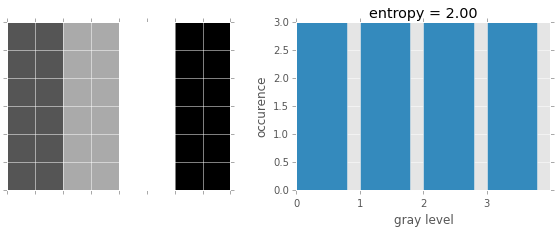

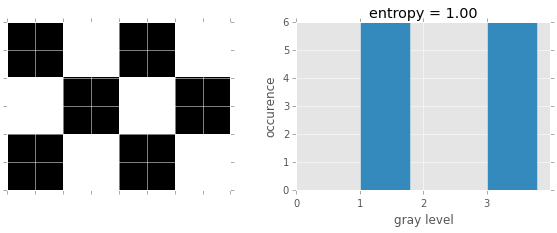

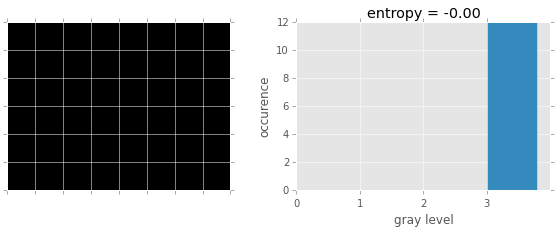

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.data import camera
plt.style.use('ggplot')

def display_hist(ima,nbin):
    hist,bins = np.histogram(ima.flatten(),bins=range(0,nbin+1))
    norm_hist = 1.*hist/np.sum(hist) # normalized histogram
    # entropy
    idx = norm_hist>0
    h = -np.sum(norm_hist[idx]*np.log2(norm_hist[idx]))
    
    # display the results
    plt.figure(figsize=[10,3])
    ax = plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray,interpolation='nearest')
    #ax.set_xticks(np.arange(nbin)-.5)
    #ax.set_yticks(np.arange(nbin)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(1,2,2)
    plt.bar(bins[:-1],hist,.8)
    if len(bins)<10:
        ax.set_xticks(bins[:-1])
        ax.set_xticklabels( bins[:-1] )
    plt.xlabel('gray level')
    plt.ylabel('occurence');
    plt.title('entropy = %.2f'%h)
    
    
i1 = np.array([[1,2,3,0],[1,2,3,0],[1,2,3,0]])
i2 = np.array([[1,3,1,3],[3,1,3,1],[1,3,1,3]])
i3 = np.array([[3,3,3,3],[3,3,3,3],[3,3,3,3]])

display_hist(i1,4)
display_hist(i2,4)
display_hist(i3,4)

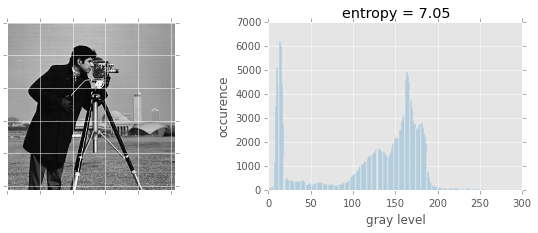

In [105]:
from skimage.data import camera

display_hist(camera(),255)

coocurence matrix

lossy image compression (jpeg/dct)

Huffman encoding

run length encoding

image pyramid (compression)

#Color representation


    color systems
    multispectral imaging (remote sensing)
    color unmixing



In [ ]:
print('Last updated: %s' %time.strftime('%d/%m/%Y'))
HTML(show_hide)